![image](resources/qcqh-lab-header.png)

# Lab 5: Quantum error correction

You can do actual insightful science with IBM Quantum devices and the knowledge you have about quantum error correction. All you need are a few tools from Qiskit.

In [1]:
# !pip install -U -r resources/requirements.txt
from qiskit import *
from IPython.display import clear_output
clear_output()


## Using a noise model

In this lab we are going to deal with noisy quantum systems, or at least simulations of them. To deal with this in Qiskit, we need to import some things.

In [2]:
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error


The following function is designed to create a noise model which will be good for what we are doing here. It has two types of noise:
* Errors on `cx` gates in which an `x`, `y` or `z` is randomly applied to each qubit.
* Errors in measurement which simulated a thermal process happening over time.

In [3]:
def make_noise(p_cx=0, T1T2Tm=(1, 1, 0)):
    '''
        Returns a noise model specified by the inputs
        - p_cx: probability of depolarizing noise on each
                qubit during a cx
        - T1T2Tm: tuple with (T1,T2,Tm), the T1 and T2 times
              and the measurement time
    '''

    noise_model = NoiseModel()

    # depolarizing error for cx
    error_cx = depolarizing_error(p_cx, 1)
    error_cx = error_cx.tensor(error_cx)
    noise_model.add_all_qubit_quantum_error(error_cx, ["cx"])

    # thermal error for measurement
    (T1, T2, Tm) = T1T2Tm
    error_meas = thermal_relaxation_error(T1, T2, Tm)
    noise_model.add_all_qubit_quantum_error(error_meas, "measure")

    return noise_model


Let's check it out on a simple four qubit circuit. One qubit has an `x` applied. Two others has a `cx`. One has nothing. Then all are measured.

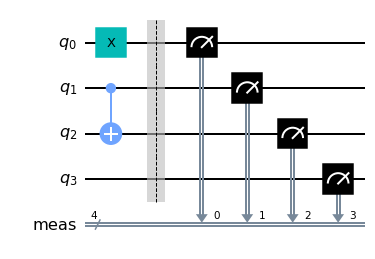

In [4]:
qc = QuantumCircuit(4)
qc.x(0)
qc.cx(1, 2)
qc.measure_all()

qc.draw(output='mpl')


This is a simple circuit with a simple output, as we'll see when we run it.

In [5]:
execute(qc, Aer.get_backend('qasm_simulator'),
        shots=8192).result().get_counts()


{'0001': 8192}

Now let's run it with noise on the `cx` gates only.

In [6]:
noise_model = make_noise(p_cx=0.1)

execute(qc, Aer.get_backend('qasm_simulator'),
        noise_model=noise_model, shots=8192).result().get_counts()


{'0011': 397, '0111': 26, '0001': 7355, '0101': 414}

The measurement noise depends on three numbers: $T_1$, $T_2$ and $T_m$. The first two describe the timescale for certain noise processes. The last describes how long measurements take. For simplicity we'll set $T_1=T_2=1$ and vary $T_m$. For $T_m=0$, the measurement is too fast to see any noise. The longer it takes, the more noise we'll see.

In [7]:
for Tm in (0.01, 0.1, 1, 10):

    noise_model = make_noise(p_cx=0, T1T2Tm=(1, 1, Tm))

    counts = execute(qc, Aer.get_backend('qasm_simulator'),
                     noise_model=noise_model, shots=8192).result().get_counts()
    print('Tm =', Tm, ', counts =', counts)


Tm = 0.01 , counts = {'0000': 76, '0001': 8116}
Tm = 0.1 , counts = {'0000': 740, '0001': 7452}
Tm = 1 , counts = {'0000': 5121, '0001': 3071}
Tm = 10 , counts = {'0001': 1, '0000': 8191}


The most notable effect of this noise is that it causes `1` values to relax down to `0`.

# Running repetition codes

Qiskit has tools to make it easy to set up, run and analyze repetition codes.

In [8]:
from qiskit.ignis.verification.topological_codes import RepetitionCode
from qiskit.ignis.verification.topological_codes import GraphDecoder
from qiskit.ignis.verification.topological_codes import lookuptable_decoding, postselection_decoding


/tmp/ipykernel_3868/2472739805.py:1: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification.topological_codes import RepetitionCode


Here's one with four repetitions and a single measurement round.

In [34]:
d = 4
T = 1
code = RepetitionCode(d, T)


The repetition code object contains a couple of circuits: for encoded logical values of `0` and `1`.

In [35]:
code.circuit


{'0': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7f291c427640>,
 '1': <qiskit.circuit.quantumcircuit.QuantumCircuit at 0x7f291c427160>}

Here's the one for `0`.

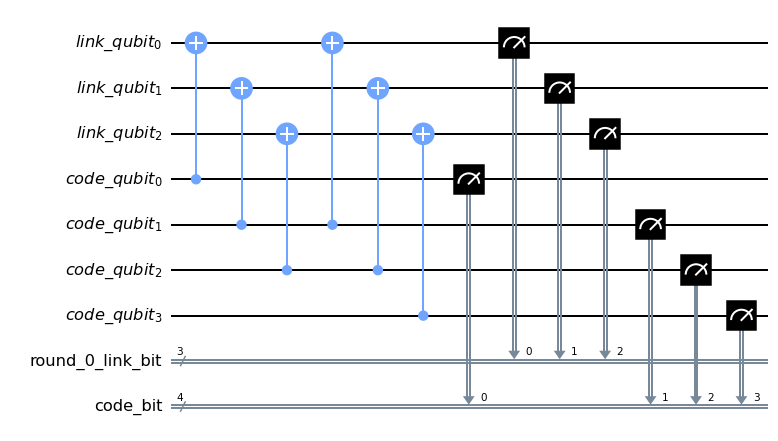

In [36]:
code.circuit['0'].draw('mpl')


And for `1`.

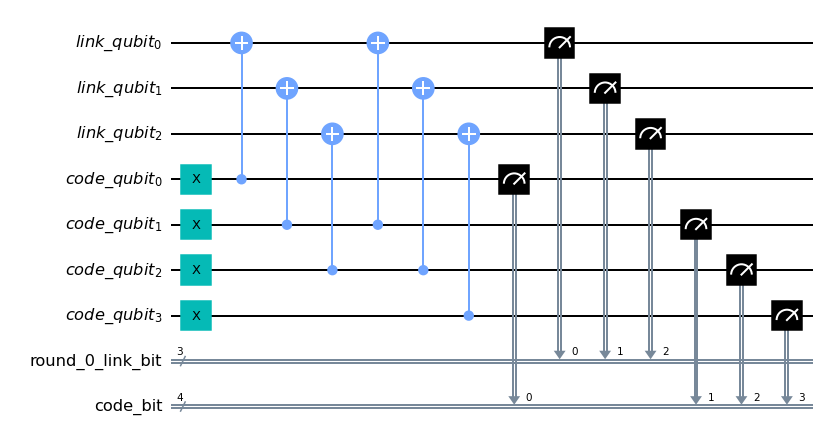

In [37]:
code.circuit['1'].draw(output='mpl')


We can run both circuits at once by first converting them into a list.

In [13]:
circuits = code.get_circuit_list()

job = execute(circuits, Aer.get_backend('qasm_simulator'),
              noise_model=noise_model, shots=8192)


Once they've run, we can extract the results and convert them into a form that allows us to more easily look at syndrome changes.

In [14]:
raw_results = {}
for log in ['0', '1']:
    raw_results[log] = job.result().get_counts(log)

results = code.process_results(raw_results)


It's easiest to just package this up into a function.

In [15]:
def get_results(code, noise_model, shots=8192):

    circuits = code.get_circuit_list()

    job = execute(circuits, Aer.get_backend('qasm_simulator'),
                  noise_model=noise_model, shots=shots)

    raw_results = {}
    for log in ['0', '1']:
        raw_results[log] = job.result().get_counts(log)

    results = code.process_results(raw_results)

    return results


First let's look at an example without any noise, to keep things simple.

In [16]:
noise_model = make_noise()  # noise model with no noise

results = get_results(code, noise_model)

results


{'0': {'0 0  000 000': 8192}, '1': {'1 1  000 000': 8192}}

Here's an example with some `cx` noise.

In [17]:
noise_model = make_noise(p_cx=0.01)

results = get_results(code, noise_model)

for log in results:
    print('\nMost common results for a stored', log)
    for output in results[log]:
        if results[log][output] > 100:
            print(output, 'ocurred for', results[log][output], 'samples.')



Most common results for a stored 0
0 0  000 000 ocurred for 7723 samples.

Most common results for a stored 1
1 1  000 000 ocurred for 7730 samples.


The main thing we need to know is the probability of a logical error. By setting up and using a decoder, we can find out!

In [18]:
decoder = GraphDecoder(code)

decoder.get_logical_prob(results)


{'0': 0.0003662109375, '1': 0.0}

By calculating these value for different sizes of code and noise models, we can learn more about how the noise will affect large circuits. This is important for error correction, but also for the applications that we'll try to run before error correction is possible.

Even more importantly, running these codes on real devices allows us to see the effects of real noise. Small-scale quantum error correction experiments like these will allow us to study the devices we have access to, understand what they do and why they do it, and test their abilities.

This is the most important exercise that you can try: doing real and insightful experiments on cutting-edge quantum hardware. It's the kind of thing that professional researchers do and write papers about. I know this because I'm one of those researchers.

See the following examples:
* ["A repetition code of 15 qubits", James R. Wootton and Daniel Loss, Phys. Rev. A 97, 052313 (2018)](https://arxiv.org/abs/1709.00990)
* ["Benchmarking near-term devices with quantum error correction", James R. Wootton, Quantum Science and Technology (2020)](https://arxiv.org/abs/2004.11037)

As well as the relevant chapter of the Qiskit textbook: [5.1 Introduction to Quantum Error Correction using Repetition Codes](https://qiskit.org/textbook/ch-quantum-hardware/error-correction-repetition-code.html).

By running repetition codes on the IBM quantum devices available to you, looking at the results and figuring out why they look like they do, you could soon know things about them that no-one else does!

## Transpiling for real devices

The first step toward using a real quantum device is to load your IBMQ account and set up the provider.

In [ ]:
IBMQ.load_account()

provider = IBMQ.get_provider(hub='ibm-q')


Now you can set up a backend object for your device of choice. We'll go for the biggest device on offer: Melbourne.

In [ ]:
backend = provider.get_backend('ibmq_16_melbourne')


Using the Jupyter tools, we can take a closer look.

In [21]:
import qiskit.tools.jupyter
%matplotlib inline

# backend


This has enough qubits to run a $d=8$ repetition code. Let's set this up and get the circuits to run.

In [ ]:
d = 8
code = RepetitionCode(8, 1)

raw_circuits = code.get_circuit_list()


Rather than show such a big circuit, let's just look at how many of each type of gate there are. For example, repetition codes should have $2(d-1)$ `cx` gates in, which means 14 in this case.

In [ ]:
raw_circuits[1].count_ops()


Before running on a real device we need to transpile. This is the process of turing the circuits into ones that the device can actually run. It is usually done automatically before running, but we can also do it ourself using the code below.

In [ ]:
circuits = []
for qc in raw_circuits:
    circuits.append(transpile(qc, backend=backend))


Let's check what this process did to the gates in the circuit.

In [ ]:
circuits[1].count_ops()


Note that this has `u3` gates (which the circuit previously didn't) and the `x` gates have disappeared. The solution to this is simple. The `x` gates have just been described as specific forms of `u3` gates, which is the way that the hardware understands single qubit operations.

More concerning is what has happened to the `cx` gates. There are now 74!.

This is due to connectivity. If you ask for a combination of `cx` gates that cannot be directly implemented, the transpiler will do some fancy tricks to make a circuit which is effectively the same as the one you want. This comes at the cost of inserting `cx` gates. For more information, see [2.4 More Circuit-Identities](https://qiskit.org/textbook/ch-gates/more-circuit-identities.html).

However, here our circuit *is* something that can be directly implemented. The transpiler just didn't realize (and figuring it out is a hard problem). We can solve the problem by telling the transpiler exactly which qubits on the device should be used as the qubits in our code.

This is done by setting up an `initial_layout` as follows.

In [26]:
def get_initial_layout(code, line):
    initial_layout = {}
    for j in range(code.d):
        initial_layout[code.code_qubit[j]] = line[2*j]
    for j in range(code.d-1):
        initial_layout[code.link_qubit[j]] = line[2*j+1]
    return initial_layout


line = [6, 5, 4, 3, 2, 1, 0, 14, 13, 12, 11, 10, 9, 8, 7]

initial_layout = get_initial_layout(code, line)

initial_layout


With this, let's try transpilation again.

In [ ]:
circuits = []
for qc in raw_circuits:
    circuits.append(transpile(qc, backend=backend,
                    initial_layout=initial_layout))

circuits[1].count_ops()


Perfect!

Now try for yourself on one of the devices that we've now retired: Tokyo.

<FakeTokyo('fake_tokyo')>

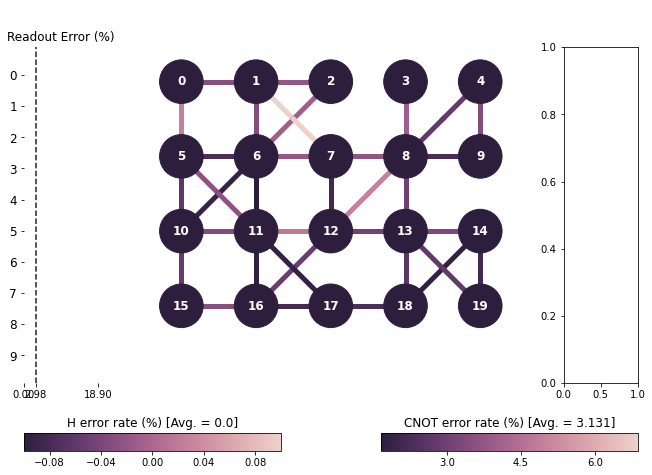

In [39]:
from qiskit.test.mock import FakeTokyo

backend = FakeTokyo()

backend


The largest repetition code this can handle is one with $d=10$.

In [41]:
d = 10
code = RepetitionCode(d, 1)
raw_circuits = code.get_circuit_list()

raw_circuits[1].count_ops()


OrderedDict([('measure', 19), ('cx', 18), ('x', 10)])

For this we need to find a line of 19 qubits across the coupling map.

In [42]:
line = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
initial_layout = get_initial_layout(code, line)

circuits = []
for qc in raw_circuits:
    circuits.append(transpile(qc, backend=backend,
                    initial_layout=initial_layout))

circuits[1].count_ops()


OrderedDict([('cx', 90), ('measure', 19), ('u3', 10), ('barrier', 1)])

Clearly, the line chosen in the cell above was not a good example. Find a line such that the transpiled circuit `circuits[1]` has exactly 18 `cx` gates.

In [71]:
line = None

# define line variable so the transpiled circuit has exactly 18 CNOTs.

# WRITE YOUR CODE BETWEEN THESE LINES - START

line = [0, 5,  10, 15,  16, 12,  13, 19,  14,
        18,  17, 11,  6, 2,  1, 7,  3, 8,  9, 4]

# WRITE YOUR CODE BETWEEN THESE LINES - END

initial_layout = get_initial_layout(code, line)

circuits = []
for qc in raw_circuits:
    circuits.append(transpile(qc, backend=backend,
                    initial_layout=initial_layout))

circuits[1].count_ops()


OrderedDict([('cx', 24), ('measure', 19), ('u3', 10), ('barrier', 1)])